In [1]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path().absolute().parent))

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

from data.datasets import PureCompoundsInTallCuvettes, COLOR_DICT
from data.data_functions import DataLoader, DerivTransform, NormalizeTransform, StaticShiftTransform
from data.plot_functions import plot_array_data, plot_confusion_matrix
from data.utils import train_test_split, sort_by_set

SEED = 378

In [2]:
exp_set = PureCompoundsInTallCuvettes()
train_set, test_set = train_test_split(exp_set, seed=SEED)

## Temporal analysis

Load data

In [3]:
psi_derivs, labels = DataLoader(exp_set, transforms=[DerivTransform, NormalizeTransform]).load()
psi_derivs_not_norm, _ = DataLoader(exp_set, transforms=[DerivTransform]).load()

Loading experimental data
(1/11) Pentane (9 exp.): [===================0] 100% complete
(2/11) Hexane (10 exp.): [===================0] 100% complete
(3/11) Heptane (3 exp.): [===================0] 100% complete
(4/11) Octane (8 exp.): [===================0] 100% complete
(5/11) Nonane (5 exp.): [===================0] 100% complete
(6/11) Decane (7 exp.): [===================0] 100% complete
(7/11) Ethanol (7 exp.): [===================0] 100% complete
(8/11) Water (7 exp.): [===================0] 100% complete
(9/11) Acetone (8 exp.): [===================0] 100% complete
(10/11) Toluene (7 exp.): [===================0] 100% complete
(11/11) Acetonitrile (5 exp.): [===================0] 100% complete
Length of experimental set loaded: 76
Loading experimental data
(1/11) Pentane (9 exp.): [===================0] 100% complete
(2/11) Hexane (10 exp.): [===================0] 100% complete
(3/11) Heptane (3 exp.): [===================0] 100% complete
(4/11) Octane (8 exp.): [===============

#### Calculate SVM

In [4]:
def predict(clf, test, lbl):
    predicted = clf.predict(test)
    print("Validation accuracy: " + str(round(np.sum(predicted == lbl)/float(len(lbl)),3)) + " (" + str(np.sum(predicted == lbl)) + "/" + str(len(lbl)) + ")")
    return predicted

In [5]:
train_data, train_lbl, test_data, test_lbl = sort_by_set(psi_derivs, train_set, test_set)

##### Find best fitting SVM classifier

In [6]:
param_grid = {"kernel":("linear", "rbf"), "C":[0.1, 1, 10, 100], "gamma": [0.1, 1, 10, 100]}

clf = GridSearchCV(svm.SVC(), param_grid, cv=LeaveOneOut())
clf.fit(train_data, train_lbl)

print(clf.best_params_)

best_scores = cross_val_score(clf.best_estimator_, train_data, train_lbl, scoring="accuracy", cv=LeaveOneOut())
print("Accuracy: %0.2f accuracy with a standard deviation of %0.2f" % (best_scores.mean(), best_scores.std()))

{'C': 10, 'gamma': 10, 'kernel': 'rbf'}
Accuracy: 0.78 accuracy with a standard deviation of 0.41


In [7]:
SVC = svm.SVC(**clf.best_params_)
SVC.fit(train_data, train_lbl)
print("Training accuracy: " + str(SVC.score(train_data, train_lbl)) + " (" + str(len(train_data)) + ")")

Training accuracy: 1.0 (50)


In [8]:
predicted = predict(SVC, test_data, test_lbl)
print(f"\nMismatches (true, pred): {[(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]}")

Validation accuracy: 0.885 (23/26)

Mismatches (true, pred): [('Octane', 'Heptane'), ('Nonane', 'Decane'), ('Acetonitrile', 'Ethanol')]


#### Plot

Validation accuracy: 0.885 (23/26)


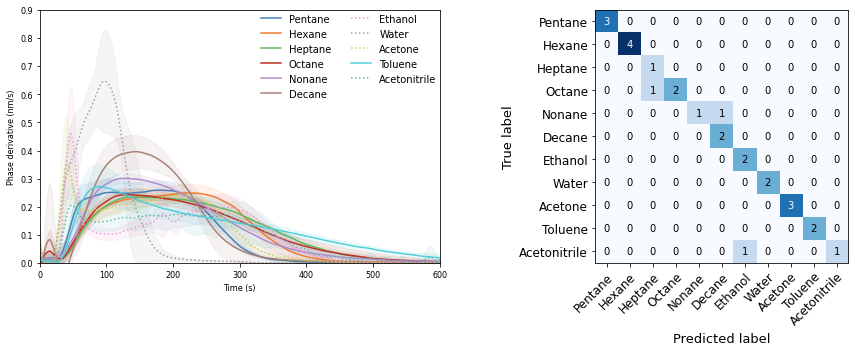

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi_derivs_not_norm, [0,600], ylim=[0,0.9], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)
axes[0].set_ylabel("Phase derivative (nm/s)")

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()
# fig.savefig('./Fig3 - Temporal analysis.svg', dpi=1200)

## Learning curve

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 0.9927272727272728 (0.010601730717900538)
Validation accuracy: 0.7690322580645162 (0.07805118521205993)


([nan,
  0.16545265348595214,
  0.21277289019224505,
  0.257741935483871,
  0.3016129032258064,
  0.33483870967741935,
  0.37161290322580653,
  0.4058064516129032,
  0.4335483870967742,
  0.46,
  0.4832258064516129,
  0.5112903225806452,
  0.5287096774193548,
  0.5461290322580645,
  0.5574193548387096,
  0.5680645161290323,
  0.58,
  0.5929032258064516,
  0.6038709677419355,
  0.6203225806451613,
  0.6277419354838709,
  0.6341935483870969,
  0.6406451612903226,
  0.6509677419354838,
  0.6664516129032259,
  0.6754838709677419,
  0.6758064516129033,
  0.6848387096774196,
  0.6919354838709678,
  0.6990322580645162,
  0.7035483870967743,
  0.7129032258064517,
  0.7203225806451613,
  0.7248387096774194,
  0.7274193548387096,
  0.7303225806451611,
  0.7361290322580645,
  0.7399999999999999,
  0.7461290322580646,
  0.7525806451612904,
  0.7538709677419355,
  0.757741935483871,
  0.763225806451613,
  0.7690322580645162],
 [nan,
  0.06350681294953825,
  0.08613374787641868,
  0.1003111703914722

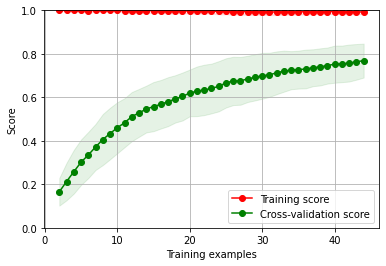

In [10]:
from sklearn.model_selection import train_test_split

def plot_learning_curve(estimator, exp_derivs, exp_concentrations, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5, ax = None):
    if ax == None:
        fig, ax = plt.subplots()
    if M == None:
        M = np.arange(1,int(len(exp_derivs)*(1-test_size)))

    train_mean = []
    train_std = []
    test_mean = []
    test_std = []

    for m in M:
        train_score = []
        test_score = []
        for state in random_seeds:
            train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs, exp_concentrations, test_size=test_size, random_state=state)
            derivs = train_derivs[0:m]
            lbls = train_lbl[0:m]
            if len(set(lbls)) < 2:
                continue
            if estimator != 'multi': # train SVR
                estimator.fit(derivs, lbls);
                score = estimator.score(test_derivs, test_lbl)
                
                if score > 0:
                    train_score.append(estimator.score(derivs, lbls))
                    test_score.append(estimator.score(test_derivs, test_lbl))
            else: 
                raise NotImplementedError

        train_mean.append(np.mean(train_score, axis=0))
        train_std.append(np.std(train_score, axis=0))
        test_mean.append(np.mean(test_score, axis=0))
        test_std.append(np.std(test_score, axis=0))

    ax.set_ylim(ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.fill_between(M , np.array(train_mean) - np.array(train_std),np.array(train_mean) + np.array(train_std), alpha=0.1,color="r")
    ax.fill_between(M, np.array(test_mean) - np.array(test_std),np.array(test_mean) + np.array(test_std), alpha=0.1, color="g")
    ax.plot(M, train_mean, 'o-', color="r",label="Training score")
    ax.plot(M, test_mean, 'o-', color="g",label="Cross-validation score")
    ax.grid()
    ax.legend(loc="lower right")

    print("Training accuracy: " + str(train_mean[-1]) + " (" + str(train_std[-1]) + ")")
    print("Validation accuracy: " + str(test_mean[-1]) + " (" + str(test_std[-1]) + ")")
    
    return test_mean, test_std, M

plot_learning_curve(SVC, [psi_derivs[k] for k in psi_derivs.keys()], [labels[k] for k in psi_derivs.keys()], ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5, ax = None)
# plt.savefig('./Fig3 - Learning curve (SI).svg', dpi=1200)

## Static analysis

Load data

In [11]:
static_shift, labels = DataLoader(exp_set, transforms=[StaticShiftTransform()]).load()

Loading experimental data
(1/11) Pentane (9 exp.): [===================0] 100% complete
(2/11) Hexane (10 exp.): [===================0] 100% complete
(3/11) Heptane (3 exp.): [===================0] 100% complete
(4/11) Octane (8 exp.): [===================0] 100% complete
(5/11) Nonane (5 exp.): [===================0] 100% complete
(6/11) Decane (7 exp.): [===================0] 100% complete
(7/11) Ethanol (7 exp.): [===================0] 100% complete
(8/11) Water (7 exp.): [===================0] 100% complete
(9/11) Acetone (8 exp.): [===================0] 100% complete
(10/11) Toluene (7 exp.): [===================0] 100% complete
(11/11) Acetonitrile (5 exp.): [===================0] 100% complete
Length of experimental set loaded: 76


#### Calculate SVM

In [12]:
train_data, train_lbl, test_data, test_lbl = sort_by_set(static_shift, train_set, test_set)

In [13]:
SVC = svm.SVC(C=10,gamma=10, kernel="rbf")
SVC.fit(train_data, train_lbl)
print("Training accuracy: " + str(SVC.score(train_data, train_lbl)) + " (" + str(len(train_data)) + ")")

Training accuracy: 0.74 (50)


In [14]:
predicted = predict(SVC, test_data, test_lbl)
print(f"\nMismatches (true, pred): {[(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]}")

Validation accuracy: 0.385 (10/26)

Mismatches (true, pred): [('Pentane', 'Hexane'), ('Hexane', 'Pentane'), ('Hexane', 'Octane'), ('Hexane', 'Octane'), ('Heptane', 'Octane'), ('Octane', 'Decane'), ('Octane', 'Acetone'), ('Nonane', 'Decane'), ('Nonane', 'Decane'), ('Decane', 'Octane'), ('Water', 'Ethanol'), ('Water', 'Ethanol'), ('Acetone', 'Ethanol'), ('Acetone', 'Water'), ('Acetonitrile', 'Acetone'), ('Acetonitrile', 'Acetone')]


#### Plot

Validation accuracy: 0.385 (10/26)


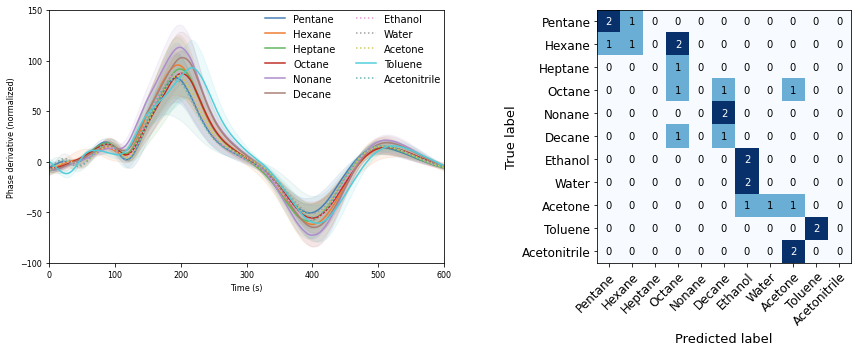

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, static_shift, [0,600], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)
axes[0].set_ylim(-100,150)

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()
plt.savefig('./Fig3 FigS6 - Static analysis (SI).svg', dpi=1200)